In [173]:
from google.oauth2.service_account import Credentials
import gspread
from googleapiclient.discovery import build
import time
import datetime
from datetime import datetime

import pandas as pd
# 출력물의 생략없이 모두 출력
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
np.set_printoptions(threshold=np.inf)

import os 
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Overview

- `접수인원` = swit에서 강의 수강을 신청하여 swit db에 저장된 인원(접수상태)  
- `수강인원` = 강의에 참석한 인원  
- `수료인원` = 강의 참석 인원 & 만족도 설문조사 제출 -> 수료증 발급 대상자


**운영 프로세스 및 이슈**
* [출석부] 강의별로 swit에서 출석부를 다운로드 (`.xlsx`)
  * 강의일 당일 참석인원을 출석부 파일에 담당자가 수기로 체크
  * 강의일 D+1부터 수집된 설문조사 제출인원을 출석부에 체크 -> 휴먼에러가 너무 많이 발생함...
  * 강의일이 지난 후 D+n 시점까지 산발적으로 설문조사 응답인원 발생 -> 수기 팔로우업에 많은 리소스 필요 및 수많은 휴먼에러 발생
* [설문조사] 강의별로 `구글폼`을 사용해 만족도 설문조사 진행
  * 강의가 종료된 직후 설문조사 링크를 제공함
  * 구글폼 응답 데이터는 `.gsheet` 으로 변환가능
  * 설문통계를 위한 별도의 프로그램이나 툴이 없어 수기로 진행해야함 -> 업무로드
* [보고] 업무 현황 파악을 위한 대시보드의 필요성
  * 정기적으로 요구되는 규격화된 통계수치 -> 루틴성 집계 리스트업 후 정기적 추출
  * 비정기적으로 요구되는 통계수치 -> 전처리된 출석부 및 설문의 통합본 관리 필요
    * 교육 현황 대시보드 제작  

**자동화 목표**
* 민진님 담당업무를 최대한 축소하여 휴먼에러 최소화
* 수시로 요구되는 현황 및 집계를 자동화하여 업무로드 최소화

# raw file load

### gsheet load

In [174]:
# 스코프 설정
scopes = ['https://www.googleapis.com/auth/spreadsheets', 'https://www.googleapis.com/auth/drive']

# 서비스 계정 키 불러오기
credentials = Credentials.from_service_account_file(
    'G:/.shortcut-targets-by-id/1pm-mzTMxN90n5Axi5ATZbh2kl8wZEOlv/2023 공공SW 수발주자 역량강화 교육 프로젝트/2.교육운영/설문조사/만족도 조사/driven-current-398407-9f03dd3a7cc6.json', scopes=scopes)

# Google Drive API 클라이언트 생성
drive_service = build('drive', 'v3', credentials=credentials)
client = gspread.authorize(credentials)

folder_id = "1YimpG6-wleIbhXLkWL3OJEauZVkWaIiQ"
query = f"'{folder_id}' in parents and mimeType='application/vnd.google-apps.spreadsheet'"
results = drive_service.files().list(q=query).execute()
file_list = results.get('files', [])

dfs = []
failed_files = []

for file in tqdm(file_list, desc="파일 처리중"):
    try:
        sheet = client.open(file['name']).sheet1
        data = sheet.get_all_values()
        df = pd.DataFrame(data[1:], columns=data[0])
        dfs.append(df)
        time.sleep(2) # 로드 실패가 자주 떠서 sleep 설정
    except Exception as e:
        failed_files.append(file['name'])

print(f"처음 로드에서 {len(file_list) - len(failed_files)}개 파일이 성공하였습니다. 실패한 파일: {len(failed_files)}개")

# 실패한 파일들에 대해 다시 로드 시도
for file_name in tqdm(failed_files, desc="실패한 파일 재처리중"):
    try:
        sheet = client.open(file_name).sheet1
        data = sheet.get_all_values()
        df = pd.DataFrame(data[1:], columns=data[0])
        dfs.append(df)
        failed_files.remove(file_name)
        time.sleep(2)
    except Exception as e:
        print(f"{file_name}에 대한 재로드 중 오류 발생: {e}")

print(f"최종적으로 로드한 파일: {len(file_list) - len(failed_files)}개, 실패한 파일: {len(failed_files)}개")


파일 처리중:   0%|          | 0/72 [00:00<?, ?it/s]

파일 처리중: 100%|██████████| 72/72 [04:33<00:00,  3.80s/it]


처음 로드에서 72개 파일이 성공하였습니다. 실패한 파일: 0개


실패한 파일 재처리중: 0it [00:00, ?it/s]

최종적으로 로드한 파일: 72개, 실패한 파일: 0개


In [175]:
for df, file in zip(dfs, file_list):
    print(f"{file['name']}의 shape: {df.shape}")

# 성공 카운트 출력
print(f"Successfully loaded {len(file_list)} files.")


0810_공공SW사업 수발주자 역량강화 교육 만족도조사(응답)의 shape: (24, 19)
1212_공공SW사업 제안요청서 상세 요구 사항 작성 교육 만족도 조사(응답)의 shape: (10, 19)
1204_공공SW사업 발주 프로세스 및 법제도 이해 교육 만족도 조사(응답)의 shape: (22, 19)
1128_공공SW사업 심화과정 감사사례 만족도 조사(응답)의 shape: (28, 19)
1201_공공SW사업 발주 프로세스 및 법제도 이해 교육 만족도 조사(응답)의 shape: (22, 19)
1207_공공SW사업 평가‧선정‧계약 및 관리감독 만족도 조사(응답)의 shape: (23, 19)
1211_공공SW사업 발주 프로세스 및 법제도 이해 교육 만족도 조사(응답)의 shape: (18, 19)
1113_공공SW사업 발주 프로세스 및 법제도 이해 교육 만족도 조사(응답)의 shape: (28, 19)
1121_공공SW사업 사업기획(예산 및 ISP)수립 교육 만족도 조사(응답)의 shape: (19, 19)
1206_공공SW사업 제안요청서 상세 요구 사항 작성 교육 만족도 조사(응답)의 shape: (20, 19)
1205_공공SW사업 사업기획(예산 및 ISP)수립 교육 만족도 조사(응답)의 shape: (19, 19)
1129_공공SW사업 제안서 작성 및 사업관리 만족도 조사(응답)의 shape: (45, 19)
1128_공공SW사업 심화과정 신기술 동향(응답)의 shape: (19, 19)
1128_공공SW사업 심화과정 과업변경 실무 만족도 조사(응답)의 shape: (26, 19)
1127_공공SW사업 발주 프로세스 및 법제도 이해 교육 만족도 조사(응답)의 shape: (17, 19)
0922_공공SW사업 제안서 작성 및 사업관리 만족도 조사(응답)의 shape: (37, 19)
1123_공공SW사업 평가‧선정‧계약 및 관리감독 만족도 조사(응답)의 shape: (19, 19)
1122_공공SW사업 제안요청서 상세 요구 사항 작성 교육 만족도 조

In [176]:
for df, file in zip(dfs, file_list):
    # 파일명에서 날짜 부분 추출
    date_str = file['name'].split('_')[0]
    
    # 날짜를 datetime 형태로 변환
    # 여기서는 2023년을 기준으로 합니다. 다른 연도를 원하시면 그에 맞게 조정하세요.
    lecture_date = datetime.strptime(f"2023{date_str}", '%Y%m%d')
    
    # '강의일' 컬럼 생성 및 값 적용
    df['강의일'] = lecture_date
    
    survey_df = pd.concat(dfs, ignore_index=True)

In [177]:
survey_df.head()

,타임스탬프,이메일 주소,성함을 입력해주세요.,소속기관의 유형을 체크해주세요.,소속기관명을 입력해주세요.,소속 부서를 입력해주세요.,수강하신 강의명을 체크해주세요.,1-1. 강의에 대해 전체적으로 만족하였다.,1-2. 교재는 강의 내용을 이해하는데 도움이 되도록 만들어졌다.,1-3. 전반적으로 교육 내용이 도움이 되었다.,1-4. 본 강의를 다른 사람에게도 추천할 의향이 있다.,1-5. 기타 의견(없으시면 생략),2-1. 강의 준비 및 열의에 만족하였다.,2-2. 강의 기법과 질문 응답 등에 만족하였다.,2-3. 강의에 대한 강사의 전문성에 만족하였다.,2-4. 기타 의견(없으시면 생략),"3-1. 환경, 조명, 소음, 화면공유 등 교육 진행 환경이 만족스러웠다.",3-2. 교육운영 인력의 교육 진행과 응대는 만족스러웠다.,3-3. 기타 의견(없으시면 생략),강의일
0,2023. 8. 10 오후 3:41:03,k25309@reb.or.kr,강미선,공공기관,한국부동산원,ICT센터,공공SW사업 평가‧선정‧계약 및 관리감독,7,7,7,7,,7,7,7,,7,7,,2023-08-10
1,2023. 8. 10 오후 3:38:50,kimbd1@korea.kr,김병도,중앙행정기관,질병관리청,정보통계담당관,공공SW사업 평가‧선정‧계약 및 관리감독,7,7,7,7,,7,7,7,,7,7,,2023-08-10
2,2023. 8. 10 오후 3:40:29,sm1017@nia.or.kr,김송민,공공기관,한국지능정보사회진흥원,디지털정부서비스팀,공공SW사업 평가‧선정‧계약 및 관리감독,7,7,7,7,,7,7,7,,7,7,,2023-08-10
3,2023. 8. 10 오후 3:40:02,epsilon@kspo.or.kr,김연권,공공기관,국민체육진흥공단,디지털서비스팀,공공SW사업 평가‧선정‧계약 및 관리감독,6,7,7,6,,7,6,6,,5,6,,2023-08-10
4,2023. 8. 10 오후 3:39:23,jwk_216@spo.go.kr,김지우,중앙행정기관,대검찰청,정보통신과,공공SW사업 평가‧선정‧계약 및 관리감독,7,7,7,7,,7,7,7,,7,7,,2023-08-10


### 출석부 load

In [178]:
# 지정된 경로
folder_path = 'G:\\.shortcut-targets-by-id\\1pm-mzTMxN90n5Axi5ATZbh2kl8wZEOlv\\2023 공공SW 수발주자 역량강화 교육 프로젝트\\2.교육운영\\강의별 수강자'

# 해당 경로에 있는 모든 파일 리스트를 가져옴
file_list = os.listdir(folder_path)

# 엑셀 파일만 필터링하면서 임시 파일 (~$로 시작하는 파일)을 제외
excel_files = [file for file in file_list if file.endswith(('.xlsx', '.xls')) and not file.startswith("~$")]

# 데이터를 저장할 빈 리스트
all_data = []

for excel_file in excel_files:
    # 각 엑셀 파일의 절대 경로
    file_path = os.path.join(folder_path, excel_file)
    
    try:
        # 엑셀 파일 불러오기
        data = pd.read_excel(file_path, engine='openpyxl')
        
        # 파일명에서 '월'과 '일' 추출
        month_day = excel_file[:4]
        # '월일'을 '강의일' 컬럼에 저장
        data['강의일'] = month_day[:2] + "월 " + month_day[2:] + "일"
        # 파일명에서 강의명 추출
        lecture_name = excel_file.split('_')[1].replace('.xlsx', '')
        data['강의명'] = lecture_name
        # 엑셀의 shape를 출력
        print(f"{excel_file}의 shape: {data.shape}")
        # 데이터 추가
        all_data.append(data)
    except Exception as e:
        print(f"{excel_file} 파일을 읽는 중 오류 발생: {e}")

# 모든 데이터를 하나의 데이터프레임으로 합치기
check_df = pd.concat(all_data, ignore_index=True)


0830_감사사례.xlsx의 shape: (88, 13)
0830_과업변경 실무.xlsx의 shape: (81, 13)
0830_신기술동향.xlsx의 shape: (117, 13)
0905_사업기획(예산 및 ISP)수립.xlsx의 shape: (80, 13)
0907_평가선정계약 및 관리감독.xlsx의 shape: (78, 13)
0919_사업기획(예산 및 ISP)수립.xlsx의 shape: (44, 13)
0920_제안요청서 상세 요구사항 작성.xlsx의 shape: (38, 13)
0921_평가선정계약 및 관리감독.xlsx의 shape: (57, 13)
0911_발주 프로세스 및 법제도 이해.xlsx의 shape: (84, 13)
0906_제안요청서 상세 요구사항 작성.xlsx의 shape: (64, 13)
0904_발주 프로세스 및 법제도 이해.xlsx의 shape: (95, 13)
0918_발주 프로세스 및 법제도 이해.xlsx의 shape: (58, 13)
0913_제안요청서 상세 요구사항 작성.xlsx의 shape: (47, 13)
0831_제안서 작성 및 사업관리.xlsx의 shape: (136, 13)
0829_제안요청서 상세 요구사항 작성.xlsx의 shape: (33, 13)
0828_발주 프로세스 및 법제도 이해.xlsx의 shape: (84, 13)
0824_평가선정계약 및 관리감독.xlsx의 shape: (70, 13)
0823_제안요청서 상세 요구사항 작성.xlsx의 shape: (58, 13)
0822_사업기획(예산 및 ISP)수립.xlsx의 shape: (93, 13)
0821_발주 프로세스 및 법제도 이해.xlsx의 shape: (69, 13)
0818_발주 프로세스 및 법제도 이해.xlsx의 shape: (78, 13)
0811_발주 프로세스 및 법제도 이해.xlsx의 shape: (119, 13)
0810_평가선정계약 및 관리감독.xlsx의 shape: (53, 13)
0809_제안요청서 상세 요구사항 작성.xlsx의 shap

In [179]:
def custom_date_parser(date_str):
    # '월'과 '일' 정보만 있는 문자열을 연도를 포함한 형식으로 변환
    return pd.to_datetime('2023-' + date_str.replace("월 ", "-").replace("일", ""), format='%Y-%m-%d')

# '강의일' 컬럼의 데이터를 'datetime64[ns]' 타입으로 변환
check_df['강의일'] = check_df['강의일'].apply(custom_date_parser)

print(check_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4522 entries, 0 to 4521
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   번호      4494 non-null   float64       
 1   성명      4522 non-null   object        
 2   기관명     4509 non-null   object        
 3   소속부서    4463 non-null   object        
 4   직급      4456 non-null   object        
 5   전화번호    4476 non-null   object        
 6   이메일     4477 non-null   object        
 7   신청일     4477 non-null   datetime64[ns]
 8   상태      4494 non-null   object        
 9   출석      2645 non-null   object        
 10  만족도 조사  1957 non-null   object        
 11  강의일     4522 non-null   datetime64[ns]
 12  강의명     4522 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(10)
memory usage: 459.4+ KB
None


In [180]:
check_df.head()

,번호,성명,기관명,소속부서,직급,전화번호,이메일,신청일,상태,출석,만족도 조사,강의일,강의명
0,1.0,장병용,이노포스트,NaN,NaN,NaN,NaN,NaT,교육신청완료,ㅇ,ㅇ,2023-08-30,감사사례
1,2.0,최석준,경상남도교육청,안전총괄과,주무관,010-2781-0824,aq3724@korea.kr,2023-08-29,교육신청완료,NaN,NaN,2023-08-30,감사사례
2,3.0,이희자,법무부 인천공항출입국.외국인청,정보관리과,팀장,032-740-7133,heejalee@korea.kr,2023-08-29,교육신청완료,NaN,NaN,2023-08-30,감사사례
3,4.0,이재훈,교육부 국사편찬위원회,연구편찬정보화실,편사연구사,02-500-8343,jhlee798@korea.kr,2023-08-25,교육신청완료,ㅇ,ㅇ,2023-08-30,감사사례
4,5.0,김은주,한국로봇산업진흥원,재무회계팀,선임,053-210-9547,ejkim@kiria.org,2023-08-24,교육신청완료,ㅇ,ㅇ,2023-08-30,감사사례


In [181]:
# '강의명'의 모든 고유값에 대해 반복
for lecture_name in check_df['강의명'].unique():
    # 현재 '강의명'에 해당하는 데이터만 필터링
    filtered_df = check_df[check_df['강의명'] == lecture_name]

    # 강의일별로 데이터를 그룹화
    grouped = filtered_df.groupby('강의일')

    # 각 그룹을 별도의 Excel 시트로 저장 (파일명에 '강의명' 포함)
    with pd.ExcelWriter(f'{lecture_name}.xlsx') as writer:
        for name, group in grouped:
            # 강의일을 datetime 객체로 변환
            date = pd.to_datetime(name)
            # '월 일' 형태로 시트 이름 설정
            sheet_name = f'{date.month}월 {date.day}일'
            group.to_excel(writer, sheet_name=sheet_name, index=False)

### 기관매핑 load

* 출석부에는 '기관유형' 정보가 존재하지 않음
* 설문을 통해 '기관유형' 정보를 입수하지만 오타, 미입력, 부정확 등 에러가 많음

In [182]:
# 파일 경로 설정
file_path = r'G:/.shortcut-targets-by-id/1pm-mzTMxN90n5Axi5ATZbh2kl8wZEOlv/2023 공공SW 수발주자 역량강화 교육 프로젝트/4.사업관리/05. 교육통계/작업물/기관매핑.xlsx'

# Excel 파일 불러오기
agency_df = pd.read_excel(file_path)

agency_df.head(2)

,기관유형,기관명
0,공공기관,(재)국가생명윤리정책원
1,공공기관,(재)예술경영지원센터


### lecture_info_raw load

In [183]:
# 파일 경로 설정
file_path = r'G:/.shortcut-targets-by-id/1pm-mzTMxN90n5Axi5ATZbh2kl8wZEOlv/2023 공공SW 수발주자 역량강화 교육 프로젝트/4.사업관리/05. 교육통계/작업물/lecuture_info_raw.xlsx'

# Excel 파일 불러오기
lecture_info_df = pd.read_excel(file_path)

lecture_info_df.head(2)

,강의일,강좌명,회차,강사,접수인원,수강인원,설문인원,만족도,강의유형,비고,영상
0,2023-08-08,공공SW사업 사업기획(예산 및 ISP)수립,1,손진락 이사,31,NaN,NaN,NaN,온라인,NaN,NaN
1,2023-08-09,공공SW사업 제안요청서 상세 요구사항 작성,1,박찬욱 교수,63,NaN,NaN,NaN,온라인,SWIT에 박동진 없음,O


* 출석부 = check_df
* 설문조사 = survey_df
* 기관매핑 = agency_df
* 강의정보 = lecture_info_df

# 전처리

### 설문조사

In [184]:
# '강의일' 컬럼의 데이터 타입을 일치
survey_df['강의일'] = survey_df['강의일'].astype('datetime64[ns]')

In [185]:
# 파일명 및 강의명 에러 확인
survey_df['수강하신 강의명을 체크해주세요.'].unique()

array(['공공SW사업 평가‧선정‧계약 및 관리감독', '공공SW사업 제안요청서 상세 요구 사항 작성',
       '공공SW사업 발주 프로세스 및 법제도 이해', '공공SW사업 감사사례',
       '공공SW사업 사업기획(예산 및 ISP)수립', '공공SW사업 제안서 작성 및 사업관리', '공공SW사업 신기술 동향',
       '공공SW사업 과업변경 실무', '공공SW사업 심화과정 과업변경 실무', '공공SW사업 심화과정 감사사례',
       '공공SW사업 심화과정 신기술 동향'], dtype=object)

In [186]:
# 강의명 통일
survey_df['수강하신 강의명을 체크해주세요.'] = survey_df['수강하신 강의명을 체크해주세요.'].replace('공공SW사업 평가·선정·계약 및 관리감독', '공공SW사업 평가‧선정‧계약 및 관리감독')
survey_df['수강하신 강의명을 체크해주세요.'] = survey_df['수강하신 강의명을 체크해주세요.'].replace('공공SW사업 제안요청서 상세 요구 사항 작성', '공공SW사업 제안요청서 상세 요구사항 작성')
survey_df['수강하신 강의명을 체크해주세요.'] = survey_df['수강하신 강의명을 체크해주세요.'].replace('공공SW사업 심화과정 과업변경 실무', '공공SW사업 과업변경 실무')
survey_df['수강하신 강의명을 체크해주세요.'] = survey_df['수강하신 강의명을 체크해주세요.'].replace('공공SW사업 심화과정 신기술 동향', '공공SW사업 신기술 동향')
survey_df['수강하신 강의명을 체크해주세요.'] = survey_df['수강하신 강의명을 체크해주세요.'].replace('공공SW사업 심화과정 감사사례', '공공SW사업 감사사례')

In [187]:
survey_df['수강하신 강의명을 체크해주세요.'].unique()

array(['공공SW사업 평가‧선정‧계약 및 관리감독', '공공SW사업 제안요청서 상세 요구사항 작성',
       '공공SW사업 발주 프로세스 및 법제도 이해', '공공SW사업 감사사례',
       '공공SW사업 사업기획(예산 및 ISP)수립', '공공SW사업 제안서 작성 및 사업관리', '공공SW사업 신기술 동향',
       '공공SW사업 과업변경 실무'], dtype=object)

In [188]:
survey_df['강좌명'] = survey_df['수강하신 강의명을 체크해주세요.']

In [189]:
# 객관식 설문 컬럼 지정
columns_to_convert_int = [
    '1-1. 강의에 대해 전체적으로 만족하였다.',
    '1-2. 교재는 강의 내용을 이해하는데 도움이 되도록 만들어졌다.',
    '1-3. 전반적으로 교육 내용이 도움이 되었다.',
    '1-4. 본 강의를 다른 사람에게도 추천할 의향이 있다.',
    '2-1. 강의 준비 및 열의에 만족하였다.',
    '2-2. 강의 기법과 질문 응답 등에 만족하였다.',
    '2-3. 강의에 대한 강사의 전문성에 만족하였다.',
    '3-1. 환경, 조명, 소음, 화면공유 등 교육 진행 환경이 만족스러웠다.',
    '3-2. 교육운영 인력의 교육 진행과 응대는 만족스러웠다.'
]

for col in columns_to_convert_int:
    survey_df[col] = survey_df[col].astype(int)

## 출석부 전처리

In [190]:
# 컬럼 순서 변경
check_df['기관유형'] = np.nan
new_column_order = ['강의일', '강의명', '번호', '성명','기관유형', '기관명', '소속부서', '직급', '전화번호', '이메일', '신청일', '상태', '출석', '만족도 조사']
check_df = check_df[new_column_order]

In [191]:
# '만족도조사' 컬럼이 null이 아닌데 '출석' 컬럼이 null인 행 검색, 휴먼에러 검출용
filtered_df = check_df[(check_df['만족도 조사'].notnull()) & (check_df['출석'].isnull())]

# 결과 개수 확인
num_rows = filtered_df.shape[0]
num_rows

0

In [192]:
survey_sub_df = survey_df[['소속기관명을 입력해주세요.', '소속기관의 유형을 체크해주세요.']]

# '출석부 통합파일.xlsx'의 '기관명' 컬럼을 기준으로 survey_sub_df와 left join을 수행하되, 중복된 행을 방지하기 위해 drop_duplicates
merged_df = check_df.merge(survey_sub_df.drop_duplicates('소속기관명을 입력해주세요.'), 
                                             left_on='기관명', 
                                             right_on='소속기관명을 입력해주세요.', 
                                             how='left')

# '소속기관의 유형을 체크해주세요.' 컬럼의 값을 '기관유형' 컬럼에 할당
merged_df['기관유형'] = merged_df['소속기관의 유형을 체크해주세요.']

# '소속기관명을 입력해주세요.'와 '소속기관의 유형을 체크해주세요.' 컬럼 삭제
merged_df.drop(columns=['소속기관명을 입력해주세요.', '소속기관의 유형을 체크해주세요.'], inplace=True)

merged_df.shape


(4522, 14)

In [193]:
# '강의명' 컬럼의 값을 통일
merged_df['강의명'] = merged_df['강의명'].replace({
    '사업기획(예산 및 ISP)수립 ': '사업기획(예산 및 ISP)수립',
    '평가‧선정‧계약 및 관리감독': '평가선정계약 및 관리감독'
})

merged_df['강의명'].unique()


array(['감사사례', '과업변경 실무', '신기술동향', '사업기획(예산 및 ISP)수립', '평가선정계약 및 관리감독',
       '제안요청서 상세 요구사항 작성', '발주 프로세스 및 법제도 이해', '제안서 작성 및 사업관리'],
      dtype=object)

In [194]:
# '출석' 컬럼의 값에 따라 0 또는 1로 변경
merged_df['출석'] = merged_df['출석'].apply(lambda x: 0 if pd.isnull(x) else 1)

merged_df['출석'].value_counts()

출석
1    2645
0    1877
Name: count, dtype: int64

In [195]:
# '만족도조사' 컬럼의 값에 따라 0 또는 1로 변경
merged_df['만족도 조사'] = merged_df['만족도 조사'].apply(lambda x: 0 if pd.isnull(x) else 1)

merged_df['만족도 조사'].value_counts()


만족도 조사
0    2565
1    1957
Name: count, dtype: int64

## 기관매핑

In [196]:
# '기관유형'이 NaN인 데이터 중, '기관명'이 agency_df의 '기관명'과 일치하는 경우 agency_df의 '기관유형' 값을 가져와서 업데이트
for index, row in merged_df[merged_df['기관유형'].isnull()].iterrows():
    matched_type = agency_df[agency_df['기관명'] == row['기관명']]['기관유형'].values
    if len(matched_type) > 0:
        merged_df.at[index, '기관유형'] = matched_type[0]

# 업데이트 된 merged_df의 첫 5개 행 확인
merged_df.head()


,강의일,강의명,번호,성명,기관유형,기관명,소속부서,직급,전화번호,이메일,신청일,상태,출석,만족도 조사
0,2023-08-30,감사사례,1.0,장병용,기타,이노포스트,NaN,NaN,NaN,NaN,NaT,교육신청완료,1,1
1,2023-08-30,감사사례,2.0,최석준,지방자치단체,경상남도교육청,안전총괄과,주무관,010-2781-0824,aq3724@korea.kr,2023-08-29,교육신청완료,0,0
2,2023-08-30,감사사례,3.0,이희자,중앙행정기관,법무부 인천공항출입국.외국인청,정보관리과,팀장,032-740-7133,heejalee@korea.kr,2023-08-29,교육신청완료,0,0
3,2023-08-30,감사사례,4.0,이재훈,중앙행정기관,교육부 국사편찬위원회,연구편찬정보화실,편사연구사,02-500-8343,jhlee798@korea.kr,2023-08-25,교육신청완료,1,1
4,2023-08-30,감사사례,5.0,김은주,공공기관,한국로봇산업진흥원,재무회계팀,선임,053-210-9547,ejkim@kiria.org,2023-08-24,교육신청완료,1,1


In [197]:
# '기관명'이 '개인'인 경우 '기관유형'을 '기타'로 변경
merged_df.loc[merged_df['기관명'] == '개인', '기관유형'] = '기타'

merged_df[merged_df['기관명'] == '개인'].head(2)

,강의일,강의명,번호,성명,기관유형,기관명,소속부서,직급,전화번호,이메일,신청일,상태,출석,만족도 조사
89,2023-08-30,과업변경 실무,2.0,장병용,기타,개인,개인,개인,010-9996-2657,helperjby@gmail.com,2023-08-29,교육신청완료,1,0
168,2023-08-30,과업변경 실무,81.0,김민진,기타,개인,개인,개인,NaN,mjk@innopost21.com,2023-08-30,교육신청완료,0,0


In [198]:
null_기관유형_df = merged_df[merged_df['기관유형'].isnull()]
null_기관유형_df['기관명'].unique()

array(['한국벤처투', '정도UIT', '세종시청', '한국벤처투자(주)', '에스엔', 'Smileserv', '블루더스',
       '서울특별시교육청 서울특별시서부교육지원청', nan, '커넥티드/기업체', '주식회사 한국무역정보통신', 'KTNET'],
      dtype=object)

## 수강인원 업데이트

In [199]:
# '강좌명' 컬럼 다시 생성 (공백 추가)
merged_df['강좌명'] = '공공SW사업 ' + merged_df['강의명']

In [200]:
# merged_df에 '강사' 컬럼을 추가 (초기값은 NaN 또는 적절한 기본값으로 설정)
merged_df['강사'] = np.nan

# lecture_info_df에서 필요한 컬럼만 선택 ('강의일', '강좌명', '강사')
lecture_info_subset = lecture_info_df[['강의일', '강좌명', '강사']]

# merged_df와 lecture_info_subset을 '강의일'과 '강좌명'을 기준으로 병합
# 'how' 매개변수는 병합 방식을 결정 ('left'는 merged_df의 모든 행을 유지)
merged_df = merged_df.merge(lecture_info_subset, on=['강의일', '강좌명'], how='left', suffixes=('', '_from_lecture'))

# 병합 결과에서 원래 '강사' 컬럼이 NaN인 경우, lecture_info_df의 '강사' 값으로 업데이트
merged_df['강사'] = merged_df.apply(lambda row: row['강사_from_lecture'] if pd.isnull(row['강사']) else row['강사'], axis=1)

# 불필요한 컬럼 제거
merged_df.drop(columns=['강사_from_lecture'], inplace=True)

In [201]:
# '월일'과 '강좌명' 기준으로 '출석' 집계
attendance_by_course = merged_df.groupby(['강의일', '강좌명'])['출석'].sum().reset_index()

attendance_by_course.head()

,강의일,강좌명,출석
0,2023-08-08,공공SW사업 사업기획(예산 및 ISP)수립,24
1,2023-08-09,공공SW사업 제안요청서 상세 요구사항 작성,39
2,2023-08-10,공공SW사업 평가선정계약 및 관리감독,29
3,2023-08-11,공공SW사업 발주 프로세스 및 법제도 이해,61
4,2023-08-18,공공SW사업 발주 프로세스 및 법제도 이해,45


In [202]:
# attendance_by_course에는 있지만 lecture_info_df에는 없는 '강의일'과 '강좌명' 조합 찾기
missing_keys = attendance_by_course[~attendance_by_course.set_index(['강의일', '강좌명']).index.isin(lecture_info_df.set_index(['강의일', '강좌명']).index)]

print(missing_keys)

Empty DataFrame
Columns: [강의일, 강좌명, 출석]
Index: []


In [203]:
# 데이터 타입 확인 및 필요시 변환
lecture_info_df['강의일'] = pd.to_datetime(lecture_info_df['강의일'])
attendance_by_course['강의일'] = pd.to_datetime(attendance_by_course['강의일'])

# 데이터 값의 공백 및 특수문자 제거
lecture_info_df['강좌명'] = lecture_info_df['강좌명'].str.strip()
attendance_by_course['강좌명'] = attendance_by_course['강좌명'].str.strip()

# 데이터 정렬
lecture_info_df = lecture_info_df.sort_values(by=['강의일', '강좌명'])
attendance_by_course = attendance_by_course.sort_values(by=['강의일', '강좌명'])

# merge
lecture_info_df = lecture_info_df.merge(attendance_by_course, on=['강의일', '강좌명'], how='left')
lecture_info_df['수강인원'] = lecture_info_df['출석'].where(lecture_info_df['출석'].notnull(), lecture_info_df['수강인원'])

# 불필요한 '출석' 컬럼 제거
lecture_info_df.drop('출석', axis=1, inplace=True)


In [204]:
lecture_info_df.tail()

,강의일,강좌명,회차,강사,접수인원,수강인원,설문인원,만족도,강의유형,비고,영상
67,2023-12-05,공공SW사업 사업기획(예산 및 ISP)수립,10,손진락 이사,43,30,NaN,NaN,온라인,NaN,NaN
68,2023-12-06,공공SW사업 제안요청서 상세 요구사항 작성,14,박찬욱 교수,51,27,NaN,NaN,온라인,NaN,NaN
69,2023-12-07,공공SW사업 평가선정계약 및 관리감독,10,이상인 VP,51,36,NaN,NaN,온라인,"12/4 설문을 노출함\n엄태두, 정해진, 양민형, 조서연, 이규찬, 정윤지, 윤재...",NaN
70,2023-12-11,공공SW사업 발주 프로세스 및 법제도 이해,20,김숙경 교수,38,22,NaN,NaN,온라인,NaN,NaN
71,2023-12-12,공공SW사업 제안요청서 상세 요구사항 작성,15,박찬욱 교수,23,13,NaN,NaN,온라인,NaN,NaN


# 설문조사 계산

In [205]:
# 새로운 컬럼을 생성
survey_df['1-1'] = survey_df['1-1. 강의에 대해 전체적으로 만족하였다.'] / 7 * 100
survey_df['1-2'] = survey_df['1-2. 교재는 강의 내용을 이해하는데 도움이 되도록 만들어졌다.'] / 7 * 100
survey_df['1-3'] = survey_df['1-3. 전반적으로 교육 내용이 도움이 되었다.'] / 7 * 100
survey_df['1-4'] = survey_df['1-4. 본 강의를 다른 사람에게도 추천할 의향이 있다.'] / 7 * 100
survey_df['2-1'] = survey_df['2-1. 강의 준비 및 열의에 만족하였다.'] / 7 * 100
survey_df['2-2'] = survey_df['2-2. 강의 기법과 질문 응답 등에 만족하였다.'] / 7 * 100
survey_df['2-3'] = survey_df['2-3. 강의에 대한 강사의 전문성에 만족하였다.'] / 7 * 100
survey_df['3-1'] = survey_df['3-1. 환경, 조명, 소음, 화면공유 등 교육 진행 환경이 만족스러웠다.'] / 7 * 100
survey_df['3-2'] = survey_df['3-2. 교육운영 인력의 교육 진행과 응대는 만족스러웠다.'] / 7 * 100


In [206]:
평균을_계산할_컬럼들 = ['1-1', '1-2', '1-3', '1-4', '2-1', '2-2', '2-3', '3-1', '3-2']

# 각 행의 평균을 계산하고 '평균' 컬럼에 추가합니다.
survey_df['평균'] = survey_df[평균을_계산할_컬럼들].mean(axis=1)
survey_df['평균'] = survey_df['평균'].round(1)

In [207]:
# '강의명' 컬럼의 값을 통일
survey_df['강좌명'] = survey_df['강좌명'].replace({
    '공공SW사업 평가‧선정‧계약 및 관리감독': '공공SW사업 평가선정계약 및 관리감독',
    '공공SW사업 신기술 동향': '공공SW사업 신기술동향'
})

survey_df['강좌명'].unique()

array(['공공SW사업 평가선정계약 및 관리감독', '공공SW사업 제안요청서 상세 요구사항 작성',
       '공공SW사업 발주 프로세스 및 법제도 이해', '공공SW사업 감사사례',
       '공공SW사업 사업기획(예산 및 ISP)수립', '공공SW사업 제안서 작성 및 사업관리', '공공SW사업 신기술동향',
       '공공SW사업 과업변경 실무'], dtype=object)

In [208]:
# '강의일', '강좌명'를 기준으로 그룹을 만들고, 해당 그룹의 개수(count)와 평균을 계산합니다.
grouped_df = survey_df.groupby(['강의일', '강좌명']).agg({
    '평균': 'mean',
    '강좌명': 'size'
}).rename(columns={'강좌명': 'new_설문인원', '평균': 'new_만족도'}).reset_index()

# 원래 데이터프레임(survey_df)를 순회하면서 '설문인원' 및 '만족도' 값을 업데이트합니다.
for idx, row in survey_df.iterrows():
    matching_row = grouped_df[
        (grouped_df['강의일'] == row['강의일']) & 
        (grouped_df['강좌명'] == row['강좌명'])
    ]
    if not matching_row.empty:
        survey_df.at[idx, '설문인원'] = matching_row['new_설문인원'].values[0]
        survey_df.at[idx, '만족도'] = matching_row['new_만족도'].values[0]

# 결과를 확인합니다.
survey_df[['강의일', '강좌명', '설문인원', '평균', '만족도']].sort_values(by='강의일').head()


,강의일,강좌명,설문인원,평균,만족도
1923,2023-08-08,공공SW사업 사업기획(예산 및 ISP)수립,21.0,87.3,86.690476
1915,2023-08-08,공공SW사업 사업기획(예산 및 ISP)수립,21.0,73.0,86.690476
1916,2023-08-08,공공SW사업 사업기획(예산 및 ISP)수립,21.0,54.0,86.690476
1917,2023-08-08,공공SW사업 사업기획(예산 및 ISP)수립,21.0,95.2,86.690476
1918,2023-08-08,공공SW사업 사업기획(예산 및 ISP)수립,21.0,87.3,86.690476


In [209]:
# '강의일'과 '강좌명'을 기준으로 두 데이터프레임을 합치되, '설문인원'과 '만족도'만 업데이트 합니다.
daily_df = lecture_info_df.merge(survey_df[['강의일', '강좌명', '설문인원', '만족도']], 
                                  on=['강의일', '강좌명'], 
                                  how='left', 
                                  suffixes=('', '_survey'))

# '설문인원'과 '만족도' 컬럼을 업데이트합니다.
daily_df['설문인원'] = daily_df['설문인원_survey'].combine_first(daily_df['설문인원'])
daily_df['만족도'] = daily_df['만족도_survey'].combine_first(daily_df['만족도'])

# 업데이트에 사용된 임시 컬럼을 삭제합니다.
daily_df.drop(columns=['설문인원_survey', '만족도_survey'], inplace=True)

# 집계

In [210]:
# survey_df에만 있는 '강좌명' 값들을 찾습니다.
unique_lecture_names_in_survey = set(survey_df['강좌명'].unique())
unique_lecture_names_in_lecture_info = set(lecture_info_df['강좌명'].unique())

missing_lecture_names = unique_lecture_names_in_survey - unique_lecture_names_in_lecture_info
missing_lecture_names

set()

In [211]:
survey_df.columns

Index(['타임스탬프', '이메일 주소', '성함을 입력해주세요.', '소속기관의 유형을 체크해주세요.', '소속기관명을 입력해주세요.',
       '소속 부서를 입력해주세요.', '수강하신 강의명을 체크해주세요.', '1-1. 강의에 대해 전체적으로 만족하였다.',
       '1-2. 교재는 강의 내용을 이해하는데 도움이 되도록 만들어졌다.', '1-3. 전반적으로 교육 내용이 도움이 되었다.',
       '1-4. 본 강의를 다른 사람에게도 추천할 의향이 있다.', '1-5. 기타 의견(없으시면 생략)',
       '2-1. 강의 준비 및 열의에 만족하였다.', '2-2. 강의 기법과 질문 응답 등에 만족하였다.',
       '2-3. 강의에 대한 강사의 전문성에 만족하였다.', '2-4. 기타 의견(없으시면 생략)',
       '3-1. 환경, 조명, 소음, 화면공유 등 교육 진행 환경이 만족스러웠다.',
       '3-2. 교육운영 인력의 교육 진행과 응대는 만족스러웠다.', '3-3. 기타 의견(없으시면 생략)', '강의일', '강좌명',
       '1-1', '1-2', '1-3', '1-4', '2-1', '2-2', '2-3', '3-1', '3-2', '평균',
       '설문인원', '만족도'],
      dtype='object')

In [212]:
# '강의일'과 '강좌명'을 기준으로 survey_df에서 '설문인원'과 '만족도'의 평균을 계산합니다.
grouped_survey = survey_df.groupby(['강의일', '강좌명'])[['설문인원', '만족도']].mean().reset_index()

# '강의일'과 '강좌명'을 기준으로 두 데이터프레임을 합칩니다.
merged_df2 = lecture_info_df.merge(grouped_survey, on=['강의일', '강좌명'], how='left', suffixes=('', '_update'))

# '설문인원'과 '만족도' 컬럼을 업데이트합니다.
merged_df2['설문인원'] = merged_df2['설문인원_update'].combine_first(merged_df2['설문인원'])
merged_df2['만족도'] = merged_df2['만족도_update'].combine_first(merged_df2['만족도'])

# 업데이트에 사용된 임시 컬럼을 삭제합니다.
merged_df2.drop(columns=['설문인원_update', '만족도_update'], inplace=True)

# 소수점 표현
merged_df2['만족도'] = merged_df2['만족도'].round(1)

# 결과를 확인합니다.
merged_df2.head()


,강의일,강좌명,회차,강사,접수인원,수강인원,설문인원,만족도,강의유형,비고,영상
0,2023-08-08,공공SW사업 사업기획(예산 및 ISP)수립,1,손진락 이사,31,24,21.0,86.7,온라인,NaN,NaN
1,2023-08-09,공공SW사업 제안요청서 상세 요구사항 작성,1,박찬욱 교수,63,39,32.0,90.0,온라인,SWIT에 박동진 없음,O
2,2023-08-10,공공SW사업 평가선정계약 및 관리감독,1,이상인 VP,54,29,24.0,89.9,온라인,"SWIT에 류연향 없음, 설문에 유태웅 중복",NaN
3,2023-08-11,공공SW사업 발주 프로세스 및 법제도 이해,1,이상인 VP,119,61,51.0,89.0,온라인,NaN,O
4,2023-08-18,공공SW사업 발주 프로세스 및 법제도 이해,2,김숙경 교수,78,45,40.0,94.4,온라인,NaN,O


In [213]:
# '강의일'과 '강좌명'을 기준으로 survey_df에서 '설문인원'과 '만족도'의 평균을 계산합니다.
grouped_survey = survey_df.groupby(['강의일', '강좌명'])[['설문인원', '만족도']].mean().reset_index()

In [214]:
grouped_survey

,강의일,강좌명,설문인원,만족도
0,2023-08-08,공공SW사업 사업기획(예산 및 ISP)수립,21.0,86.690476
1,2023-08-09,공공SW사업 제안요청서 상세 요구사항 작성,32.0,90.031250
2,2023-08-10,공공SW사업 평가선정계약 및 관리감독,24.0,89.945833
3,2023-08-11,공공SW사업 발주 프로세스 및 법제도 이해,51.0,88.982353
4,2023-08-18,공공SW사업 발주 프로세스 및 법제도 이해,40.0,94.445000
5,2023-08-21,공공SW사업 발주 프로세스 및 법제도 이해,26.0,90.711538
6,2023-08-22,공공SW사업 사업기획(예산 및 ISP)수립,45.0,91.288889
7,2023-08-23,공공SW사업 제안요청서 상세 요구사항 작성,30.0,90.843333
8,2023-08-24,공공SW사업 평가선정계약 및 관리감독,30.0,91.163333
9,2023-08-28,공공SW사업 발주 프로세스 및 법제도 이해,44.0,94.984091


In [215]:
# '강의일'과 '강좌명'을 기준으로 lecture_info_df와 grouped_survey를 merge합니다.
merged_df2 = lecture_info_df.merge(grouped_survey, on=['강의일', '강좌명'], how='left', suffixes=('', '_update'))

# '설문인원'과 '만족도' 컬럼을 업데이트합니다.
merged_df2['설문인원'] = merged_df2['설문인원_update'].combine_first(merged_df2['설문인원'])
merged_df2['만족도'] = merged_df2['만족도_update'].combine_first(merged_df2['만족도'])

# 업데이트에 사용된 임시 컬럼을 삭제합니다.
merged_df2.drop(columns=['설문인원_update', '만족도_update'], inplace=True)

# 소수점 표현
merged_df2['만족도'] = merged_df2['만족도'].round(1)

# 결과를 확인합니다.
merged_df2.head()

,강의일,강좌명,회차,강사,접수인원,수강인원,설문인원,만족도,강의유형,비고,영상
0,2023-08-08,공공SW사업 사업기획(예산 및 ISP)수립,1,손진락 이사,31,24,21.0,86.7,온라인,NaN,NaN
1,2023-08-09,공공SW사업 제안요청서 상세 요구사항 작성,1,박찬욱 교수,63,39,32.0,90.0,온라인,SWIT에 박동진 없음,O
2,2023-08-10,공공SW사업 평가선정계약 및 관리감독,1,이상인 VP,54,29,24.0,89.9,온라인,"SWIT에 류연향 없음, 설문에 유태웅 중복",NaN
3,2023-08-11,공공SW사업 발주 프로세스 및 법제도 이해,1,이상인 VP,119,61,51.0,89.0,온라인,NaN,O
4,2023-08-18,공공SW사업 발주 프로세스 및 법제도 이해,2,김숙경 교수,78,45,40.0,94.4,온라인,NaN,O


## 강좌별 통계

In [216]:
# 주어진 순서로 정렬을 위한 순서 정보 저장
order_dict = {
    '공공SW사업 발주 프로세스 및 법제도 이해': 1,
    '공공SW사업 사업기획(예산 및 ISP)수립': 2,
    '공공SW사업 제안요청서 상세 요구사항 작성': 3,
    '공공SW사업 평가선정계약 및 관리감독': 4,
    '공공SW사업 제안서 작성 및 사업관리': 5,
    '공공SW사업 감사사례': 6,
    '공공SW사업 과업변경 실무': 7,
    '공공SW사업 신기술동향': 8
}

In [217]:
# 월과 강좌명을 기준으로 집계
lecture_summary2 = merged_df2.groupby(['강좌명']).agg({
    '접수인원': 'sum',
    '수강인원': 'sum',
    '설문인원': 'sum',
    '만족도': 'mean'
}).reset_index()

# 소수점 표현
lecture_summary2['만족도'] = lecture_summary2['만족도'].round(1)

# '강좌명' 기준으로 정렬
lecture_summary2['order'] = lecture_summary2['강좌명'].map(order_dict)
lecture_summary2 = lecture_summary2.sort_values(by='order').drop(columns='order')

# 결과
lecture_summary2.head()

,강좌명,접수인원,수강인원,설문인원,만족도
2,공공SW사업 발주 프로세스 및 법제도 이해,1223,750,607.0,90.0
3,공공SW사업 사업기획(예산 및 ISP)수립,528,323,254.0,91.0
6,공공SW사업 제안요청서 상세 요구사항 작성,660,411,316.0,91.6
7,공공SW사업 평가선정계약 및 관리감독,565,345,265.0,92.1
5,공공SW사업 제안서 작성 및 사업관리,525,291,199.0,91.0


## 강좌별-월별 통계

In [218]:
tem_merged_df2 = merged_df2.copy()

# '강의일' 컬럼에서 월 정보만 추출하여 '월' 컬럼 생성
tem_merged_df2['월'] = tem_merged_df2['강의일'].dt.month

# 월과 강좌명을 기준으로 집계
lecture_summary3 = tem_merged_df2.groupby(['강좌명', '월']).agg({
    '접수인원': 'sum',
    '수강인원': 'sum',
    '설문인원': 'sum',
    '만족도': 'mean'
}).reset_index()

# 소수점 표현
lecture_summary3['만족도'] = lecture_summary3['만족도'].round(1)

# '강좌명' 기준으로 주어진 순서대로 정렬
lecture_summary3['order'] = lecture_summary3['강좌명'].map(order_dict)
lecture_summary3 = lecture_summary3.sort_values(by=['order', '월']).drop(columns='order')

# 결과
lecture_summary3.head()

,강좌명,월,접수인원,수강인원,설문인원,만족도
8,공공SW사업 발주 프로세스 및 법제도 이해,8,350,193,161.0,92.3
9,공공SW사업 발주 프로세스 및 법제도 이해,9,286,187,160.0,92.3
10,공공SW사업 발주 프로세스 및 법제도 이해,10,257,160,124.0,89.0
11,공공SW사업 발주 프로세스 및 법제도 이해,11,201,130,100.0,87.7
12,공공SW사업 발주 프로세스 및 법제도 이해,12,129,80,62.0,88.8


## 월별-강좌별 통계

In [219]:
# '강의일' 컬럼에서 월 정보만 추출하여 '월' 컬럼 생성
tem_merged_df2['월'] = tem_merged_df2['강의일'].dt.month

# 월과 강좌명을 기준으로 집계
lecture_summary4 = tem_merged_df2.groupby(['월', '강좌명']).agg({
    '접수인원': 'sum',
    '수강인원': 'sum',
    '설문인원': 'sum',
    '만족도': 'mean'
}).reset_index()

# 소수점 표현
lecture_summary4['만족도'] = lecture_summary4['만족도'].round(1)

# '강좌명' 기준으로 주어진 순서대로 정렬
lecture_summary4['order'] = lecture_summary4['강좌명'].map(order_dict)
lecture_summary4 = lecture_summary4.sort_values(by=['월', 'order']).drop(columns='order')

# 결과
lecture_summary4.head()


,월,강좌명,접수인원,수강인원,설문인원,만족도
2,8,공공SW사업 발주 프로세스 및 법제도 이해,350,193,161.0,92.3
3,8,공공SW사업 사업기획(예산 및 ISP)수립,124,73,66.0,89.0
6,8,공공SW사업 제안요청서 상세 요구사항 작성,154,100,81.0,91.5
7,8,공공SW사업 평가선정계약 및 관리감독,124,69,54.0,90.6
5,8,공공SW사업 제안서 작성 및 사업관리,136,65,52.0,91.4


## 저장

In [220]:
# 현재 날짜 가져오기
current_date = datetime.now().strftime('%m%d')

lecture_file_name = '강의 통계 정보_{}.xlsx'.format(current_date)

# 전체 경로 생성
save_path = 'G:/.shortcut-targets-by-id/1pm-mzTMxN90n5Axi5ATZbh2kl8wZEOlv/2023 공공SW 수발주자 역량강화 교육 프로젝트/4.사업관리/05. 교육통계/'
full_path = save_path + lecture_file_name

# 데이터프레임을 각각의 시트에 .xlsx 파일로 저장
with pd.ExcelWriter(full_path) as writer:
    merged_df2.to_excel(writer, sheet_name='강의정보', index=False)
    lecture_summary2.to_excel(writer, sheet_name='강좌별', index=False)
    lecture_summary3.to_excel(writer, sheet_name='강좌별-월별', index=False)
    lecture_summary4.to_excel(writer, sheet_name='월별-강좌별', index=False)

# 수강생 집계

In [221]:
check_df.shape

(4522, 14)

In [222]:
check_df['이메일'].nunique()

1346

In [223]:
filtered_df = check_df.dropna(subset=['출석'])
u_check_df = filtered_df.drop_duplicates(subset='이메일')


In [224]:
# 저장 경로 설정
file_path = save_path + '/작업물/u_check_df.xlsx'

# .xlsx 형식으로 저장
u_check_df.to_excel(file_path, index=False, engine='openpyxl')

In [225]:
e_count = filtered_df['이메일'].value_counts()
f_e_count = e_count[e_count < 14]
print(f_e_count)

이메일
naoesky@korea.kr                  13
dlsdudska@kangwon.ac.kr           12
kyi123@ice.go.kr                  10
yoonjo@kpf.or.kr                  10
deux4yhs@korea.kr                 10
comdbsgml2@poba.or.kr             10
dkjung@kogas.or.kr                 9
kjhan54@komsco.com                 9
jwyoon0415@seoulshinbo.co.kr       9
sjkim@kict.re.kr                   8
tcik@kict.re.kr                    8
hseongbin@gjf.or.kr                8
change777@police.go.kr             8
dochai@nia.or.kr                   8
robot8469@korea.kr                 8
kimhj1207@epis.or.kr               8
sksong@bisco.or.kr                 8
kim.hj@kofta.org                   8
jji7385@bohun.or.kr                8
yongtaes@redcross.or.kr            8
swzooc@krri.re.kr                  8
mycom@kau.ac.kr                    8
ehlee@seoulshinbo.co.kr            8
jalome@nia.or.kr                   8
jhseo@kiost.ac.kr                  8
hwgoo@kogas.or.kr                  8
yj@kpf.or.kr                      

In [226]:
f_e_count.describe()

count    1044.000000
mean        2.368774
std         1.892363
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        13.000000
Name: count, dtype: float64

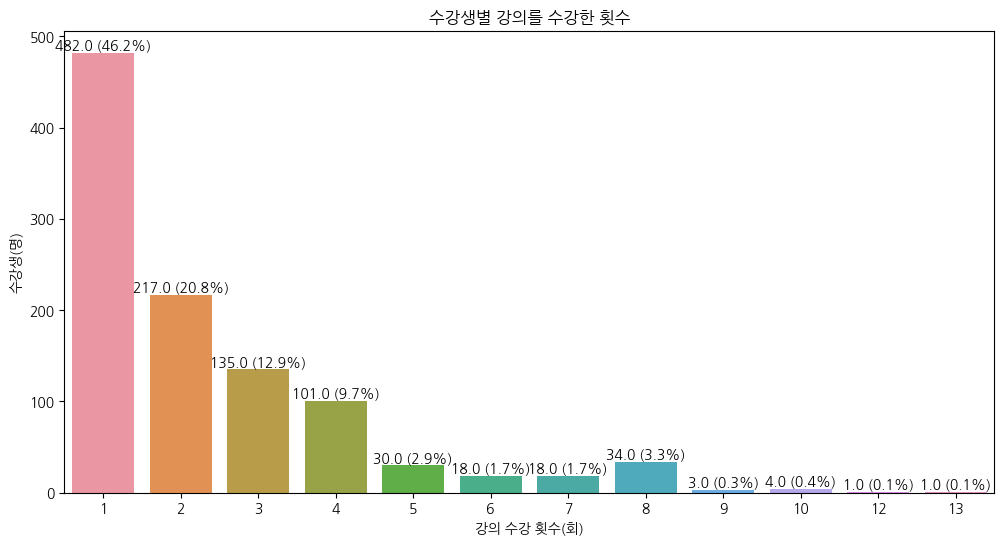

In [227]:
import seaborn as sns
import matplotlib.pyplot as plt


# 카운트 플롯 생성
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=f_e_count)

total = len(f_e_count)  # 전체 데이터 개수
# 각 막대 위에 레이블 추가
for p in ax.patches:
    height = p.get_height()  # 막대의 높이 (빈도수)
    percentage = 100 * height / total  # 전체 대비 비율 계산
    ax.annotate(f'{height} ({percentage:.1f}%)', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('수강생별 강의를 수강한 횟수')
plt.xlabel('강의 수강 횟수(회)')
plt.ylabel('수강생(명)')
plt.show()

1044명

# 기관 집계

## 기관유형 결측값 추출

In [228]:
merged_df.isnull().sum()

강의일        0
강의명        0
번호        28
성명         0
기관유형      36
기관명       13
소속부서      59
직급        66
전화번호      46
이메일       45
신청일       45
상태        28
출석         0
만족도 조사     0
강좌명        0
강사         0
dtype: int64

In [229]:
null_rows = merged_df[merged_df['기관유형'].isnull()]

In [230]:
# '기관명' 컬럼만 선택
selected_data = null_rows['기관명']

# 저장 경로 설정
file_path = save_path + '/작업물/기관명_결측값.xlsx'

# .xlsx 형식으로 저장
selected_data.to_excel(file_path, index=False, engine='openpyxl')

## 기관유형별 분류

In [231]:
# '출석' 컬럼의 각 값의 빈도 계산
value_counts = merged_df['출석'].value_counts()

# 각 값의 비율 계산
attendance_ratio = value_counts / len(merged_df)

# 결과 출력
print(attendance_ratio)

출석
1    0.584918
0    0.415082
Name: count, dtype: float64


In [232]:
merged_check = merged_df[merged_df['출석']==1]
class_institutions = merged_check.groupby(['강의명'])['기관유형'].value_counts()
class_institutions

강의명               기관유형  
감사사례              공공기관      102
                  중앙행정기관     32
                  지방자치단체     11
                  기타         10
                  민간기업        9
                  지방공공기관      8
과업변경 실무           공공기관       90
                  중앙행정기관     31
                  민간기업       13
                  지방자치단체     11
                  기타          8
                  지방공공기관      7
발주 프로세스 및 법제도 이해  공공기관      324
                  민간기업      190
                  중앙행정기관    127
                  지방자치단체     42
                  기타         37
                  지방공공기관     27
사업기획(예산 및 ISP)수립  공공기관      177
                  중앙행정기관     77
                  지방자치단체     17
                  기타         17
                  지방공공기관     16
                  민간기업       15
신기술동향             민간기업       72
                  공공기관       71
                  중앙행정기관     21
                  기타         12
                  지방공공기관      8
                  지방자치단체      7
제안서 작성 및 사업관리  

In [233]:
# 집계한 데이터를 unstack을 사용하여 transpose
transposed_df = class_institutions.unstack(fill_value=0).reset_index()

# 강의명을 첫 번째 컬럼으로 설정
transposed_df.columns.name = None  # Remove the column name
transposed_df = transposed_df.rename(columns={"강의명": "Unnamed: 0"})

# 'Unnamed: 0'을 '강의명'으로 변경
transposed_df = transposed_df.rename(columns={"Unnamed: 0": "강의명"})

# 컬럼 순서 변경
new_order = ['강의명', '공공기관', '중앙행정기관', '지방공공기관', '지방자치단체', '민간기업', '기타']
transposed_df = transposed_df[new_order]

transposed_df

,강의명,공공기관,중앙행정기관,지방공공기관,지방자치단체,민간기업,기타
0,감사사례,102,32,8,11,9,10
1,과업변경 실무,90,31,7,11,13,8
2,발주 프로세스 및 법제도 이해,324,127,27,42,190,37
3,사업기획(예산 및 ISP)수립,177,77,16,17,15,17
4,신기술동향,71,21,8,7,72,12
5,제안서 작성 및 사업관리,77,19,8,7,164,9
6,제안요청서 상세 요구사항 작성,235,85,20,27,12,30
7,평가선정계약 및 관리감독,187,82,21,24,11,16


In [234]:
# 행의 순서 변경
new_row_order = [
    '발주 프로세스 및 법제도 이해',
    '사업기획(예산 및 ISP)수립',
    '제안요청서 상세 요구사항 작성',
    '평가선정계약 및 관리감독',
    '제안서 작성 및 사업관리',
    '감사사례',
    '과업변경 실무',
    '신기술동향'
]

ordered_df = transposed_df.set_index('강의명').loc[new_row_order].reset_index()
ordered_df


,강의명,공공기관,중앙행정기관,지방공공기관,지방자치단체,민간기업,기타
0,발주 프로세스 및 법제도 이해,324,127,27,42,190,37
1,사업기획(예산 및 ISP)수립,177,77,16,17,15,17
2,제안요청서 상세 요구사항 작성,235,85,20,27,12,30
3,평가선정계약 및 관리감독,187,82,21,24,11,16
4,제안서 작성 및 사업관리,77,19,8,7,164,9
5,감사사례,102,32,8,11,9,10
6,과업변경 실무,90,31,7,11,13,8
7,신기술동향,71,21,8,7,72,12


# 설문집계

## 과목별-설문문항별 평균

In [235]:
# 필요한 열 선택
columns_of_interest = ['강좌명', '1-1. 강의에 대해 전체적으로 만족하였다.', '1-2. 교재는 강의 내용을 이해하는데 도움이 되도록 만들어졌다.', '1-3. 전반적으로 교육 내용이 도움이 되었다.', '1-4. 본 강의를 다른 사람에게도 추천할 의향이 있다.', '2-1. 강의 준비 및 열의에 만족하였다.', '2-2. 강의 기법과 질문 응답 등에 만족하였다.', '2-3. 강의에 대한 강사의 전문성에 만족하였다.', '3-1. 환경, 조명, 소음, 화면공유 등 교육 진행 환경이 만족스러웠다.', '3-2. 교육운영 인력의 교육 진행과 응대는 만족스러웠다.']
survey_filtered = survey_df[columns_of_interest]

# 강좌별로 그룹화 및 평균 계산
grouped_averages = survey_filtered.groupby('강좌명').mean()

# 집계 결과 출력
grouped_averages

,1-1. 강의에 대해 전체적으로 만족하였다.,1-2. 교재는 강의 내용을 이해하는데 도움이 되도록 만들어졌다.,1-3. 전반적으로 교육 내용이 도움이 되었다.,1-4. 본 강의를 다른 사람에게도 추천할 의향이 있다.,2-1. 강의 준비 및 열의에 만족하였다.,2-2. 강의 기법과 질문 응답 등에 만족하였다.,2-3. 강의에 대한 강사의 전문성에 만족하였다.,"3-1. 환경, 조명, 소음, 화면공유 등 교육 진행 환경이 만족스러웠다.",3-2. 교육운영 인력의 교육 진행과 응대는 만족스러웠다.
강좌명,,,,,,,,,
공공SW사업 감사사례,6.491803,6.475410,6.459016,6.508197,6.573770,6.467213,6.581967,6.483607,6.500000
공공SW사업 과업변경 실무,6.344538,6.378151,6.361345,6.319328,6.394958,6.369748,6.361345,6.394958,6.436975
공공SW사업 발주 프로세스 및 법제도 이해,6.395387,5.555189,6.364086,6.385502,6.514003,6.436573,6.530478,6.387150,6.448105
공공SW사업 사업기획(예산 및 ISP)수립,6.381890,6.334646,6.354331,6.354331,6.437008,6.389764,6.464567,6.311024,6.377953
공공SW사업 신기술동향,6.215827,6.208633,6.172662,6.129496,6.302158,6.230216,6.302158,6.071942,6.237410
공공SW사업 제안서 작성 및 사업관리,6.331658,6.261307,6.311558,6.306533,6.452261,6.326633,6.427136,6.336683,6.356784
공공SW사업 제안요청서 상세 요구사항 작성,6.395570,6.408228,6.408228,6.398734,6.487342,6.357595,6.465190,6.408228,6.449367
공공SW사업 평가선정계약 및 관리감독,6.449057,6.407547,6.494340,6.452830,6.509434,6.456604,6.535849,6.350943,6.513208


In [236]:
# grouped_averages를 Excel 파일로 저장
# grouped_averages.to_excel('grouped_averages.xlsx')
grouped_averages.to_excel('G:/.shortcut-targets-by-id/1pm-mzTMxN90n5Axi5ATZbh2kl8wZEOlv/2023 공공SW 수발주자 역량강화 교육 프로젝트/4.사업관리/05. 교육통계/작업물/grouped_averages.xlsx')


## 월별-강의별-문항별 평균점수 추출

In [237]:
# '강의일'에서 월 정보 추출
survey_df['월'] = pd.to_datetime(survey_df['강의일']).dt.month

# 필요한 열 선택
columns_of_interest = ['강좌명', '월', '1-1. 강의에 대해 전체적으로 만족하였다.', '1-2. 교재는 강의 내용을 이해하는데 도움이 되도록 만들어졌다.', '1-3. 전반적으로 교육 내용이 도움이 되었다.', '1-4. 본 강의를 다른 사람에게도 추천할 의향이 있다.', '2-1. 강의 준비 및 열의에 만족하였다.', '2-2. 강의 기법과 질문 응답 등에 만족하였다.', '2-3. 강의에 대한 강사의 전문성에 만족하였다.', '3-1. 환경, 조명, 소음, 화면공유 등 교육 진행 환경이 만족스러웠다.', '3-2. 교육운영 인력의 교육 진행과 응대는 만족스러웠다.']
survey_filtered = survey_df[columns_of_interest]

# 월별 및 강좌명별로 그룹화 및 평균 계산
monthly_grouped_averages = survey_filtered.groupby(['월', '강좌명']).mean()

# 집계 결과 출력
monthly_grouped_averages.head()

1-1. 강의에 대해 전체적으로 만족하였다.  \
월 강좌명                                                 
8 공공SW사업 감사사례                              6.531915   
  공공SW사업 과업변경 실무                           6.666667   
  공공SW사업 발주 프로세스 및 법제도 이해                  6.472050   
  공공SW사업 사업기획(예산 및 ISP)수립                  6.333333   
  공공SW사업 신기술동향                             6.333333   

                           1-2. 교재는 강의 내용을 이해하는데 도움이 되도록 만들어졌다.  \
월 강좌명                                                             
8 공공SW사업 감사사례                                          6.553191   
  공공SW사업 과업변경 실무                                       6.666667   
  공공SW사업 발주 프로세스 및 법제도 이해                              6.453416   
  공공SW사업 사업기획(예산 및 ISP)수립                              6.303030   
  공공SW사업 신기술동향                                         6.190476   

                           1-3. 전반적으로 교육 내용이 도움이 되었다.  \
월 강좌명                                                   
8 공공SW사업 감사사례                                6.468085   
  공공SW사업 과업변경 실무                             6.638889   
  공공SW사업 발주 프로세스 및 법제도 이해                    6.472050   
  공공SW사업 사업기획(예산 및 ISP)수립                    6.257576   
  공공SW사업 신기술동향                               6.142857   

                           1-4. 본 강의를 다른 사람에게도 추천할 의향이 있다.  \
월 강좌명                                                        
8 공공SW사업 감사사례                                     6.531915   
  공공SW사업 과업변경 실무                                  6.666667   
  공공SW사업 발주 프로세스 및 법제도 이해                         6.472050   
  공공SW사업 사업기획(예산 및 ISP)수립                         6.287879   
  공공SW사업 신기술동향                                    6.071429   

                           2-1. 강의 준비 및 열의에 만족하였다.  \
월 강좌명                                                
8 공공SW사업 감사사례                             6.617021   
  공공SW사업 과업변경 실무                          6.722222   
  공공SW사업 발주 프로세스 및 법제도 이해                 6.540373   
  공공SW사업 사업기획(예산 및 ISP)수립                 6.378788   
  공공SW사업 신기술동향                            6.380952   

                           2-2. 강의 기법과 질문 응답 등에 만족하였다.  \
월 강좌명                                                    
8 공공SW사업 감사사례                                 6.574468   
  공공SW사업 과업변경 실무                              6.694444   
  공공SW사업 발주 프로세스 및 법제도 이해                     6.484472   
  공공SW사업 사업기획(예산 및 ISP)수립                     6.257576   
  공공SW사업 신기술동향                                6.333333   

                           2-3. 강의에 대한 강사의 전문성에 만족하였다.  \
월 강좌명                                                    
8 공공SW사업 감사사례                                 6.617021   
  공공SW사업 과업변경 실무                              6.694444   
  공공SW사업 발주 프로세스 및 법제도 이해                     6.552795   
  공공SW사업 사업기획(예산 및 ISP)수립                     6.393939   
  공공SW사업 신기술동향                                6.309524   

                           3-1. 환경, 조명, 소음, 화면공유 등 교육 진행 환경이 만족스러웠다.  \
월 강좌명                                                                  
8 공공SW사업 감사사례                                               6.553191   
  공공SW사업 과업변경 실무                                            6.500000   
  공공SW사업 발주 프로세스 및 법제도 이해                                   6.236025   
  공공SW사업 사업기획(예산 및 ISP)수립                                   6.136364   
  공공SW사업 신기술동향                                              6.404762   

                           3-2. 교육운영 인력의 교육 진행과 응대는 만족스러웠다.  
월 강좌명                                                        
8 공공SW사업 감사사례                                      6.510638  
  공공SW사업 과업변경 실무                                   6.638889  
  공공SW사업 발주 프로세스 및 법제도 이해                          6.440994  
  공공SW사업 사업기획(예산 및 ISP)수립                          6.242424  
  공공SW사업 신기술동향                                     6.428571

In [238]:
# grouped_averages를 Excel 파일로 저장
monthly_grouped_averages.to_excel('montly_grouped_averages.xlsx')


## 기타 의견 추출

In [239]:
# 2. '기타 의견' 컬럼 생성
def count_non_empty_values(row):
    return row[['1-5. 기타 의견(없으시면 생략)', '2-4. 기타 의견(없으시면 생략)', '3-3. 기타 의견(없으시면 생략)']].apply(lambda x: x != '').sum()

survey_df['기타 의견'] = survey_df.apply(count_non_empty_values, axis=1)

# 3. '1-5. 기타 의견(없으시면 생략)', '2-4. 기타 의견(없으시면 생략)', '3-3. 기타 의견(없으시면 생략)' 컬럼의 값을 합치기
survey_df[['1-5. 기타 의견(없으시면 생략)', '2-4. 기타 의견(없으시면 생략)', '3-3. 기타 의견(없으시면 생략)']] = survey_df[['1-5. 기타 의견(없으시면 생략)', '2-4. 기타 의견(없으시면 생략)', '3-3. 기타 의견(없으시면 생략)']].fillna('')
survey_df['모든 의견'] = survey_df[['1-5. 기타 의견(없으시면 생략)', '2-4. 기타 의견(없으시면 생략)', '3-3. 기타 의견(없으시면 생략)']].agg(', '.join, axis=1).str.replace(r'(,)\s+', '', regex=True).str.strip(', ')

# 4. '강의일'과 '신청기관' 별로 그룹화하고, '모든 의견' 컬럼의 값들을 개행 문자('\n')로 구분하여 합침
grouped = survey_df.groupby(['강좌명'])['모든 의견'].agg(lambda x: '\n'.join(filter(None, x))).reset_index()

In [240]:
grouped

,강좌명,모든 의견
0,공공SW사업 감사사례,없음없음..\n강사님 말씀이 귀에 잘 들어왔습니다.\n다양한 감사 사례를 확인할수...
1,공공SW사업 과업변경 실무,"ㅡㅡㅡ\n...,.\n모든 강의는 13시 정각이 아닌 13시 20~30분에 시작했으..."
2,공공SW사업 발주 프로세스 및 법제도 이해,좋은 강의 준비해주셔서 감사합니다. 숙지해야 할 내용들이 많이 있던데오늘 강의 오디...
3,공공SW사업 사업기획(예산 및 ISP)수립,업무로 집중에 듣질못했으나 유익한 교육이었습니다. 다음번 재수강가능하다면 재수강해보...
4,공공SW사업 신기술동향,공공기관의 교육시간 확보를 위해 공문으로도 교육안내를 받을 수 있으면 좋겠습니다\n...
5,공공SW사업 제안서 작성 및 사업관리,생략생략생략\n수고하셨습니다.\n--\nㅡㅡㅡ\n교육이 더 많으면 좋겠습니다~\n어...
6,공공SW사업 제안요청서 상세 요구사항 작성,종종 강사님께서 판서를 하는 경우가 있는데 글씨를 이해하기 살짝 어려웠습니다없음\n...
7,공공SW사업 평가선정계약 및 관리감독,제안요청서 상세 요구사항 작성 과정과 내용이 중복되는 부분이 있다.\n오프라인 강의...


In [241]:
# 5. 불필요한 ', ' 제거 및 '기타 의견', '만족도' 추가
grouped_final = survey_df.groupby(['강좌명']).agg({'기타 의견': 'sum', '만족도': 'mean'}).reset_index()
grouped_final

,강좌명,기타 의견,만족도
0,공공SW사업 감사사례,18,92.922951
1,공공SW사업 과업변경 실무,24,91.049580
2,공공SW사업 발주 프로세스 및 법제도 이해,154,90.494234
3,공공SW사업 사업기획(예산 및 ISP)수립,53,91.117717
4,공공SW사업 신기술동향,22,88.680576
5,공공SW사업 제안서 작성 및 사업관리,43,90.648241
6,공공SW사업 제안요청서 상세 요구사항 작성,67,91.708228
7,공공SW사업 평가선정계약 및 관리감독,48,92.330189


In [242]:
# 5. 불필요한 ', ' 제거 및 '기타 의견', '만족도' 추가
grouped_final = survey_df.groupby(['강좌명']).agg({'기타 의견': 'sum', '만족도': 'mean'}).reset_index()
final_df = pd.merge(grouped, grouped_final, on=['강좌명'])
final_df = final_df[['강좌명', '만족도', '기타 의견', '모든 의견']]

final_df.head()

,강좌명,만족도,기타 의견,모든 의견
0,공공SW사업 감사사례,92.922951,18,없음없음..\n강사님 말씀이 귀에 잘 들어왔습니다.\n다양한 감사 사례를 확인할수...
1,공공SW사업 과업변경 실무,91.049580,24,"ㅡㅡㅡ\n...,.\n모든 강의는 13시 정각이 아닌 13시 20~30분에 시작했으..."
2,공공SW사업 발주 프로세스 및 법제도 이해,90.494234,154,좋은 강의 준비해주셔서 감사합니다. 숙지해야 할 내용들이 많이 있던데오늘 강의 오디...
3,공공SW사업 사업기획(예산 및 ISP)수립,91.117717,53,업무로 집중에 듣질못했으나 유익한 교육이었습니다. 다음번 재수강가능하다면 재수강해보...
4,공공SW사업 신기술동향,88.680576,22,공공기관의 교육시간 확보를 위해 공문으로도 교육안내를 받을 수 있으면 좋겠습니다\n...


In [244]:
# lecture_info_df에서 필요한 컬럼만 선택 ('강의일', '강좌명', '강사')
lecture_info_subset = lecture_info_df[['강의일', '강좌명', '강사']]

# survey_df와 lecture_info_subset을 '강의일'과 '강좌명'을 기준으로 병합
# 'how' 매개변수는 병합 방식을 결정 ('left'는 survey_df의 모든 행을 유지)
survey_df2 = survey_df.merge(lecture_info_subset, on=['강의일', '강좌명'], how='left', suffixes=('', '_from_lecture'))

# 병합 결과에서 원래 '강사' 컬럼이 NaN인 경우, lecture_info_df의 '강사' 값으로 업데이트
survey_df2['강사'] = survey_df2.apply(lambda row: row['강사_from_lecture'] if pd.isnull(row['강사']) else row['강사'], axis=1)

survey_df.shape

(2021, 36)

In [245]:
opinion_columns = ['강사', '강좌명', '1-5. 기타 의견(없으시면 생략)', '2-4. 기타 의견(없으시면 생략)', '3-3. 기타 의견(없으시면 생략)']
opinion_data = survey_df2[opinion_columns]

# 강좌명을 기준으로 데이터를 그룹화하고 각 의견을 리스트로 집계
aggregated_opinions = opinion_data.groupby(['강사', '강좌명']).agg(lambda x: [i for i in x if i])

# 쉼표를 개행문자로 변경하여 각 의견을 줄로 구분
aggregated_opinions = aggregated_opinions.applymap(lambda x: '\n'.join(x))

aggregated_opinions # 처음 몇 개의 결과를 표시합니다.

1-5. 기타 의견(없으시면 생략)  \
강사     강좌명                                                                          
김숙경 교수 공공SW사업 발주 프로세스 및 법제도 이해  좋은 강의 준비해주셔서 감사합니다. 숙지해야 할 내용들이 많이 있던데, 오늘 강의 ...   
박준호 박사 공공SW사업 제안서 작성 및 사업관리     생략\n수고하셨습니다.\n-\nㅡ\n교육이 더 많으면 좋겠습니다~\n좋은 강의엿다\...   
박찬욱 교수 공공SW사업 발주 프로세스 및 법제도 이해                    교제를 읽는것보다 다양한 예시가 화면에 나오면 좋겠습니다   
       공공SW사업 제안요청서 상세 요구사항 작성  종종 강사님께서 판서를 하는 경우가 있는데 글씨를 이해하기 살짝 어려웠습니다\n필기...   
손진락 이사 공공SW사업 과업변경 실무                      3시간정도로 편성되어야한다고 생각됨\n핸드폰으로 해서 설문하기 불편함   
       공공SW사업 사업기획(예산 및 ISP)수립  업무로 집중에 듣질못했으나 유익한 교육이었습니다. 다음번 재수강가능하다면 재수강해보...   
이상인 VP 공공SW사업 감사사례              없음\n다양한 감사 사례를 확인할수 있는 기회가 되었습니다. 실무에 적용할수 있게 ...   
       공공SW사업 과업변경 실무           ㅡ\n.\n모든 강의는 13시 정각이 아닌 13시 20~30분에 시작했으면 좋겠습니...   
       공공SW사업 발주 프로세스 및 법제도 이해  마이크 소리가 너무 울려요\n카이스트 김숙경교수님 강의로 듣고 싶습니다.\n좋은교육...   
       공공SW사업 신기술동향             .,\n프로필을 이름/소속/부서 로 설정하여 참석자의 신상이 공유되는 것에 대해 다...   
       공공SW사업 평가선정계약 및 관리감독     제안요청서 상세 요구사항 작성 과정과 내용이 중복되는 부분이 있다.\n오프라인 강의...   
이원재 상무 공공SW사업 신기술동향             제안요청서 작성과 사업관리시의 중요사항에 관한 내용 필요\n.\n신기술동향의 적용기...   

                                                              2-4. 기타 의견(없으시면 생략)  \
강사     강좌명                                                                          
김숙경 교수 공공SW사업 발주 프로세스 및 법제도 이해  너무 빠르다..\n감사합니다.\n생략\n글로만 설명해주신게 아니라 표나 차트등을 적...   
박준호 박사 공공SW사업 제안서 작성 및 사업관리     생략\n-\nㅡ\n어려웠어요\n강사님 열과 성의를 다해 강의하셧다\n없습니다\n잘들...   
박찬욱 교수 공공SW사업 발주 프로세스 및 법제도 이해                                                      
       공공SW사업 제안요청서 상세 요구사항 작성  없음\n.\nㅡ\n.\n교수님께서 현업에서 겪으신 사례를 바탕으로 직설적(?)으로 ...   
손진락 이사 공공SW사업 과업변경 실무                                   강의를 어렵게 하시네요\n핸드폰 해서 불편함    
       공공SW사업 사업기획(예산 및 ISP)수립  열정적인 강의 감사드립니다.\nㅡ\n수고하셨습니다 \n감사합니다\n만족합니다.\n....   
이상인 VP 공공SW사업 감사사례              없음\n강사님 말씀이  귀에 잘 들어왔습니다.\n수고하셨습니다.\nㅡ\n중간 중간 ...   
       공공SW사업 과업변경 실무           ㅡ\n..\n커뮤니티 소통\n강사님이 실무위주로 설명을 잘해주셨습니다.\n강사님이 ...   
       공공SW사업 발주 프로세스 및 법제도 이해  좋은교육이었습니다\n잘 들었습니다.\n감사합니다\n.\n없음\n고생하셨습니다\n다시...   
       공공SW사업 신기술동향                                                            .,   
       공공SW사업 평가선정계약 및 관리감독     감사합니다 \nㅡ\n감사합니다 \n열정적으로 강의해주셨어요\n강사님의 실무경험, 감...   
이원재 상무 공공SW사업 신기술동향                           감사합니다.\n강사님 설명 이해하기가 조금 어려웠습니다.\n없음   

                                                              3-3. 기타 의견(없으시면 생략)  
강사     강좌명                                                                         
김숙경 교수 공공SW사업 발주 프로세스 및 법제도 이해  배경음악이 너무 좋네요. 경쾌하고 편안한 마음으로 즐감했습니다. ^^\n생략\n없음...  
박준호 박사 공공SW사업 제안서 작성 및 사업관리     생략\nㅡ\n1시간마다 쉬는 시간이 있었으면 \n없음\n업습니다\n소리가 안들린 적...  
박찬욱 교수 공공SW사업 발주 프로세스 및 법제도 이해         (교수님 말고) 교육진행자 카톡소리는 안나도록 하는 것이 좋을 것 같습니다.  
       공공SW사업 제안요청서 상세 요구사항 작성  .\nㅡ\n.\n교수님 마이크가 조금 울려서 음질이 개선되었으면 좋겠습니다.\n강사...  
손진락 이사 공공SW사업 과업변경 실무                                                          없음  
       공공SW사업 사업기획(예산 및 ISP)수립  ㅡ\n수고하셨습니다 \n감사합니다.\n.\n교안에 설명해주시는 부분들도 추가해주시면...  
이상인 VP 공공SW사업 감사사례              ..\n메일로 안내할때 교재도 함께 보내주셨으면 더 좋았을것같습니다.\nㅡ\n고생하...  
       공공SW사업 과업변경 실무           ㅡ\n,.\n교재를 채팅창에 올려주세요.\n-\n교육시간 변경으로 혼란이 있어서 아...  
       공공SW사업 발주 프로세스 및 법제도 이해  좋은교육이었 습니다\n울리는 소리가 꽤나 들렸습니다.\n.\n마이크 울림이 있어 좀...  
       공공SW사업 신기술동향             공공기관의 교육시간 확보를 위해 공문으로도 교육안내를 받을 수 있으면 좋겠습니다 \...  
       공공SW사업 평가선정계약 및 관리감독     ㅡ\n감사합니다\n \n감사합니다 \n4개 과정 수강중 기능점수 산정 등 중복되는 ...  
이원재 상무 공공SW사업 신기술동향             음성이 자주 끊김\n재택교육으로 들어서 집중할 수 있어 좋았습니다.\n교육 자료가 ...

In [246]:
# '강사'와 '강좌명'을 기준으로 데이터를 그룹화
grouped_opinions = opinion_data.groupby(['강사', '강좌명'])

# 각 의견 컬럼의 비어 있지 않은 응답의 총 합 계산
opinion_counts = grouped_opinions.agg(lambda x: x.apply(lambda y: 1 if y else 0).sum())

# 총 합을 나타내는 새로운 컬럼 이름 지정
opinion_count_columns = ['1-5. 의견 총합', '2-4. 의견 총합', '3-3. 의견 총합']
opinion_counts.columns = opinion_count_columns

# 원래의 집계된 의견 데이터프레임과 개수 데이터프레임을 합치기
aggregated_opinions_with_counts = pd.concat([aggregated_opinions, opinion_counts], axis=1)

In [247]:
# 결과 확인
aggregated_opinions_with_counts.head(10)

1-5. 기타 의견(없으시면 생략)  \
강사     강좌명                                                                          
김숙경 교수 공공SW사업 발주 프로세스 및 법제도 이해  좋은 강의 준비해주셔서 감사합니다. 숙지해야 할 내용들이 많이 있던데, 오늘 강의 ...   
박준호 박사 공공SW사업 제안서 작성 및 사업관리     생략\n수고하셨습니다.\n-\nㅡ\n교육이 더 많으면 좋겠습니다~\n좋은 강의엿다\...   
박찬욱 교수 공공SW사업 발주 프로세스 및 법제도 이해                    교제를 읽는것보다 다양한 예시가 화면에 나오면 좋겠습니다   
       공공SW사업 제안요청서 상세 요구사항 작성  종종 강사님께서 판서를 하는 경우가 있는데 글씨를 이해하기 살짝 어려웠습니다\n필기...   
손진락 이사 공공SW사업 과업변경 실무                      3시간정도로 편성되어야한다고 생각됨\n핸드폰으로 해서 설문하기 불편함   
       공공SW사업 사업기획(예산 및 ISP)수립  업무로 집중에 듣질못했으나 유익한 교육이었습니다. 다음번 재수강가능하다면 재수강해보...   
이상인 VP 공공SW사업 감사사례              없음\n다양한 감사 사례를 확인할수 있는 기회가 되었습니다. 실무에 적용할수 있게 ...   
       공공SW사업 과업변경 실무           ㅡ\n.\n모든 강의는 13시 정각이 아닌 13시 20~30분에 시작했으면 좋겠습니...   
       공공SW사업 발주 프로세스 및 법제도 이해  마이크 소리가 너무 울려요\n카이스트 김숙경교수님 강의로 듣고 싶습니다.\n좋은교육...   
       공공SW사업 신기술동향             .,\n프로필을 이름/소속/부서 로 설정하여 참석자의 신상이 공유되는 것에 대해 다...   

                                                              2-4. 기타 의견(없으시면 생략)  \
강사     강좌명                                                                          
김숙경 교수 공공SW사업 발주 프로세스 및 법제도 이해  너무 빠르다..\n감사합니다.\n생략\n글로만 설명해주신게 아니라 표나 차트등을 적...   
박준호 박사 공공SW사업 제안서 작성 및 사업관리     생략\n-\nㅡ\n어려웠어요\n강사님 열과 성의를 다해 강의하셧다\n없습니다\n잘들...   
박찬욱 교수 공공SW사업 발주 프로세스 및 법제도 이해                                                      
       공공SW사업 제안요청서 상세 요구사항 작성  없음\n.\nㅡ\n.\n교수님께서 현업에서 겪으신 사례를 바탕으로 직설적(?)으로 ...   
손진락 이사 공공SW사업 과업변경 실무                                   강의를 어렵게 하시네요\n핸드폰 해서 불편함    
       공공SW사업 사업기획(예산 및 ISP)수립  열정적인 강의 감사드립니다.\nㅡ\n수고하셨습니다 \n감사합니다\n만족합니다.\n....   
이상인 VP 공공SW사업 감사사례              없음\n강사님 말씀이  귀에 잘 들어왔습니다.\n수고하셨습니다.\nㅡ\n중간 중간 ...   
       공공SW사업 과업변경 실무           ㅡ\n..\n커뮤니티 소통\n강사님이 실무위주로 설명을 잘해주셨습니다.\n강사님이 ...   
       공공SW사업 발주 프로세스 및 법제도 이해  좋은교육이었습니다\n잘 들었습니다.\n감사합니다\n.\n없음\n고생하셨습니다\n다시...   
       공공SW사업 신기술동향                                                            .,   

                                                              3-3. 기타 의견(없으시면 생략)  \
강사     강좌명                                                                          
김숙경 교수 공공SW사업 발주 프로세스 및 법제도 이해  배경음악이 너무 좋네요. 경쾌하고 편안한 마음으로 즐감했습니다. ^^\n생략\n없음...   
박준호 박사 공공SW사업 제안서 작성 및 사업관리     생략\nㅡ\n1시간마다 쉬는 시간이 있었으면 \n없음\n업습니다\n소리가 안들린 적...   
박찬욱 교수 공공SW사업 발주 프로세스 및 법제도 이해         (교수님 말고) 교육진행자 카톡소리는 안나도록 하는 것이 좋을 것 같습니다.   
       공공SW사업 제안요청서 상세 요구사항 작성  .\nㅡ\n.\n교수님 마이크가 조금 울려서 음질이 개선되었으면 좋겠습니다.\n강사...   
손진락 이사 공공SW사업 과업변경 실무                                                          없음   
       공공SW사업 사업기획(예산 및 ISP)수립  ㅡ\n수고하셨습니다 \n감사합니다.\n.\n교안에 설명해주시는 부분들도 추가해주시면...   
이상인 VP 공공SW사업 감사사례              ..\n메일로 안내할때 교재도 함께 보내주셨으면 더 좋았을것같습니다.\nㅡ\n고생하...   
       공공SW사업 과업변경 실무           ㅡ\n,.\n교재를 채팅창에 올려주세요.\n-\n교육시간 변경으로 혼란이 있어서 아...   
       공공SW사업 발주 프로세스 및 법제도 이해  좋은교육이었 습니다\n울리는 소리가 꽤나 들렸습니다.\n.\n마이크 울림이 있어 좀...   
       공공SW사업 신기술동향             공공기관의 교육시간 확보를 위해 공문으로도 교육안내를 받을 수 있으면 좋겠습니다 \...   

                                1-5. 의견 총합  2-4. 의견 총합  3-3. 의견 총합  
강사     강좌명                                                          
김숙경 교수 공공SW사업 발주 프로세스 및 법제도 이해          66          32          18  
박준호 박사 공공SW사업 제안서 작성 및 사업관리             23          11           9  
박찬욱 교수 공공SW사업 발주 프로세스 및 법제도 이해           1           0           1  
       공공SW사업 제안요청서 상세 요구사항 작성          35          17          15  
손진락 이사 공공SW사업 과업변경 실무                    2           2           1  
       공공SW사업 사업기획(예산 및 ISP)수립          23          17          13  
이상인 VP 공공SW사업 감사사례                       7           6           5  
       공공SW사업 과업변경 실무                    8           5           6  
       공공SW사업 발주 프로세스 및 법제도 이해          15           9          12  
       공공SW사업 신기술동향                      2           1           3

In [248]:
# 현재 날짜를 YYMMDD 형식으로 포맷팅
formatted_date = date.today().strftime("%y%m%d")

# Excel 파일명에 날짜를 포함하여 저장
file_name = f'강사별 피드백(3분할)_{formatted_date}.xlsx'
aggregated_opinions_with_counts.to_excel(file_name)

# 강좌별-출석부 추출

In [ ]:
# final_df를 Excel 파일로 저장
survey_df.to_excel('설문통합.xlsx')

In [ ]:
# survey_df와 lecture_info_df를 '강의일'과 '강좌명'을 기준으로 병합
merged_df = survey_df.merge(lecture_info_df, on=['강의일', '강좌명'], how='left')

# 결과 확인
merged_df.head(1)


,타임스탬프,이메일 주소,성함을 입력해주세요.,소속기관의 유형을 체크해주세요.,소속기관명을 입력해주세요.,소속 부서를 입력해주세요.,수강하신 강의명을 체크해주세요.,1-1. 강의에 대해 전체적으로 만족하였다.,1-2. 교재는 강의 내용을 이해하는데 도움이 되도록 만들어졌다.,1-3. 전반적으로 교육 내용이 도움이 되었다.,1-4. 본 강의를 다른 사람에게도 추천할 의향이 있다.,1-5. 기타 의견(없으시면 생략),2-1. 강의 준비 및 열의에 만족하였다.,2-2. 강의 기법과 질문 응답 등에 만족하였다.,2-3. 강의에 대한 강사의 전문성에 만족하였다.,2-4. 기타 의견(없으시면 생략),"3-1. 환경, 조명, 소음, 화면공유 등 교육 진행 환경이 만족스러웠다.",3-2. 교육운영 인력의 교육 진행과 응대는 만족스러웠다.,3-3. 기타 의견(없으시면 생략),강의일,강좌명,1-1,1-2,1-3,1-4,2-1,2-2,2-3,3-1,3-2,평균,설문인원_x,만족도_x,월,기타 의견,모든 의견,회차,강사,접수인원,수강인원,설문인원_y,만족도_y,강의유형,비고,영상
0,2023. 12. 12 오후 4:48:13,hyein1305@komsco.com,김혜인,공공기관,한국조폐공사,ICT기획보안처,공공SW사업 제안요청서 상세 요구사항 작성,7,7,7,7,,7,7,7,,7,7,,2023-12-12,공공SW사업 제안요청서 상세 요구사항 작성,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,10.0,95.07,12,0,,15,박찬욱 교수,23,13,NaN,NaN,온라인,NaN,NaN


In [ ]:
# '강의명'의 모든 고유값에 대해 반복
for lecture_name in survey_df['강좌명'].unique():
    # 현재 '강의명'에 해당하는 데이터만 필터링
    filtered_df = survey_df[survey_df['강좌명'] == lecture_name]

    # 강의일별로 데이터를 그룹화
    grouped = filtered_df.groupby('강의일')

    # 각 그룹을 별도의 Excel 시트로 저장 (파일명에 '강의명' 포함)
    with pd.ExcelWriter(f'{lecture_name}.xlsx') as writer:
        for name, group in grouped:
            # 강의일을 datetime 객체로 변환
            date = pd.to_datetime(name)
            # '월 일' 형태로 시트 이름 설정
            sheet_name = f'{date.month}월 {date.day}일'
            group.to_excel(writer, sheet_name=sheet_name, index=False)